In [33]:
import tensorflow_datasets as tfds
import tensorflow as tf
#pip install tfds-nightly 

In [34]:
datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

In [35]:
metadatos#caracteristicas de los datos...

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='C:\\Users\\Miguel Angel\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }

In [36]:
datos_entrenamiento = datos['train']
datos_pruebas = datos['test']

In [37]:
nombres_clases = metadatos.features['label'].names #nombres de datos

In [38]:
#debemso tranformar los datos, es decir convertir los numeros de 0 a 255 de 0 a 1
#
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes = imagenes/255
    return imagenes, etiquetas


datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)



#agregar cache
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

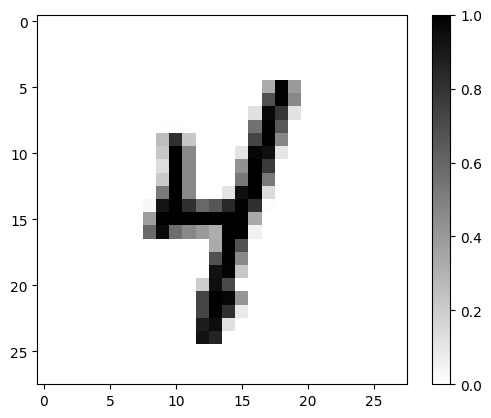

In [39]:
for imagen, etiqueta in datos_entrenamiento.take(1):
    break

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()#barra lateral
plt.show()

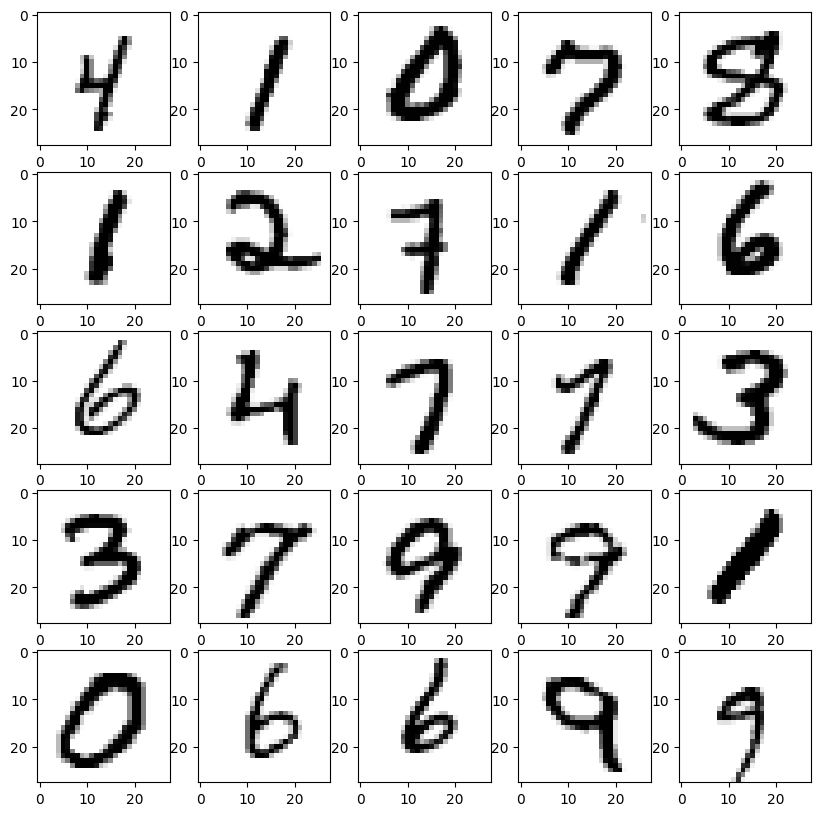

In [40]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    plt.subplot(5, 5, i+1)
    plt.imshow(imagen, cmap=plt.cm.binary)
plt.show()

In [41]:
#nuestro modelo
modelo = tf.keras.Sequential([
        #784 datos de entrada... (pixeles de la img)
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),#flatten lo aplaana a una sola columna
    ####capa oculta
    tf.keras.layers.Dense(50, activation=tf.nn.relu),#capa en medio, le vamos a especificar una activacion
    tf.keras.layers.Dense(50, activation=tf.nn.relu),#capa en medio, relo apra numeros de 0 y 1
    #capa de salida
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)#que nos clasifique en 10 formas distintas, y nos de numeros, el mayor.. aja..
])

In [42]:
#copilar modelo
modelo.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), #nuevos metodos de emdicion de error
    metrics=['accuracy'],#3xactitud del modelo
)

In [43]:
#tenemos 70mil datos, necesitamos optimizar todo...
TAMANO_LOTE = 32 #lotes de 32 en 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(60000).batch(TAMANO_LOTE) # si termina veulva a mepzar
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [44]:
#ENTRENAMIENTOOOOO
import math
entrenamiento= modelo.fit(
    datos_entrenamiento, epochs = 10,
    steps_per_epoch=math.ceil(60000/TAMANO_LOTE)
)

Epoch 1/10


1875/1875 [==============================] - 16s 5ms/step - loss: 0.3077 - accuracy: 0.9093
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1439 - accuracy: 0.9581
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1034 - accuracy: 0.9684
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0840 - accuracy: 0.9738
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0743 - accuracy: 0.9769
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0613 - accuracy: 0.9811
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0541 - accuracy: 0.9832
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0472 - accuracy: 0.9849
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0420 - accuracy: 0.9861
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0360 - accu

1/1 [==============================] - 1s 1s/step


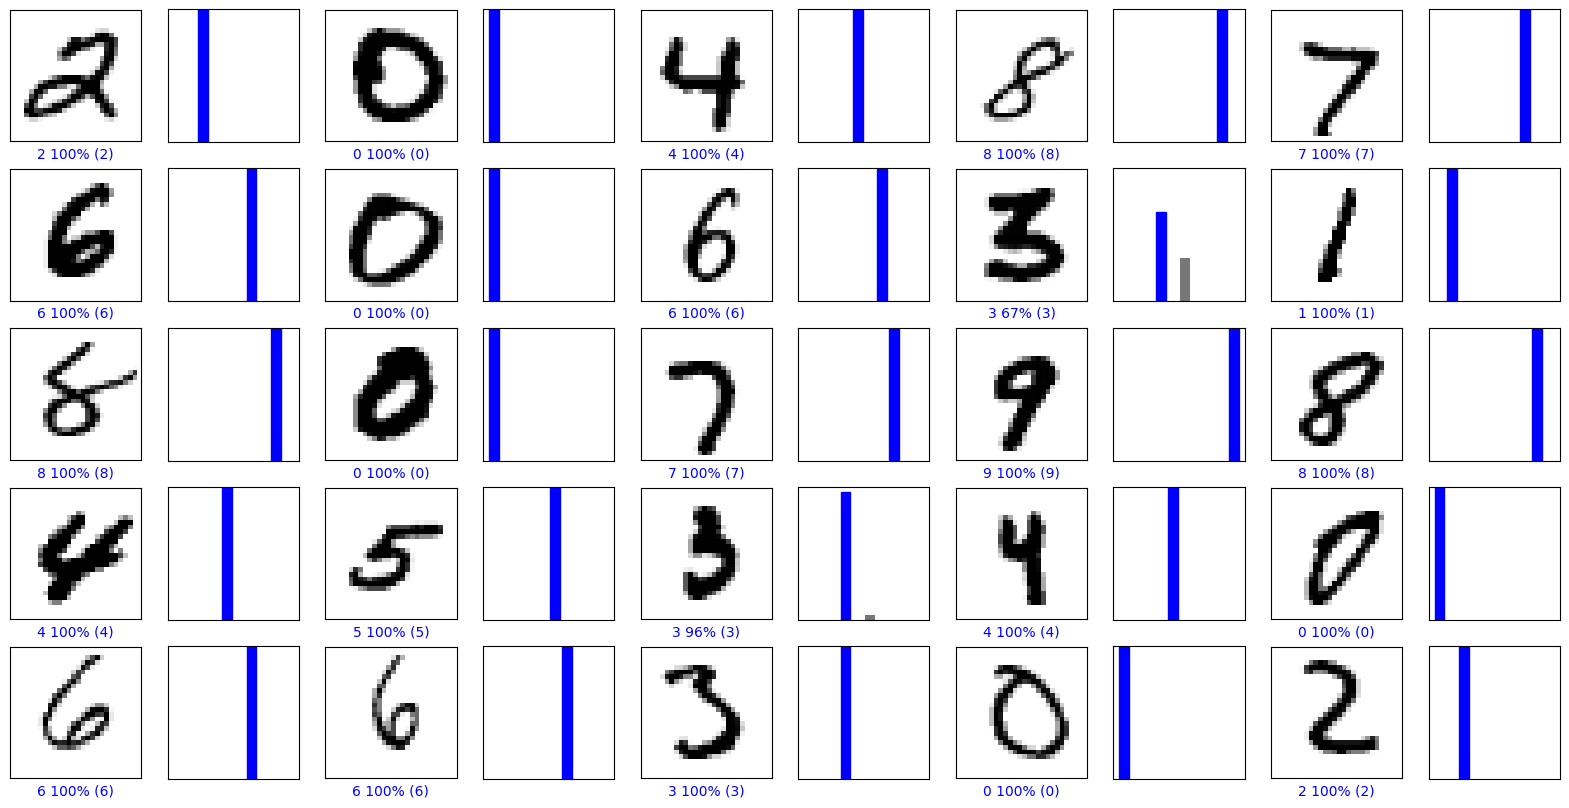

In [45]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)